In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import scipy as sp
import glob
import os
import random
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import pickle

# Plot some sample images

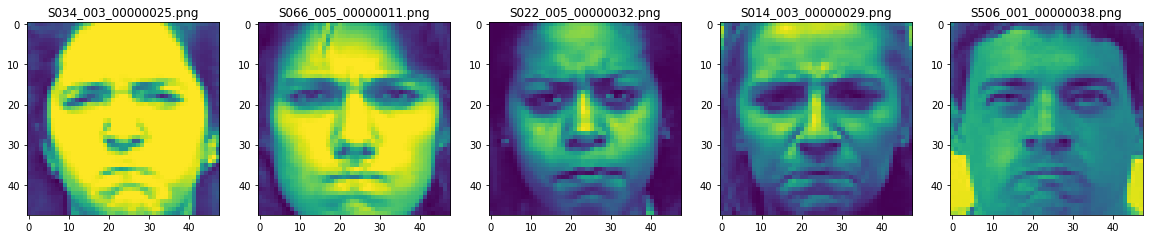

In [ ]:
# plot some sample of dataset
plt.figure(figsize=(20,20))
#test_folder=r'/content/drive/My Drive/CS486 Project/CK+48/anger'
test_folder=r'/content/drive/My Drive/CK+48/anger'#Basil: My drive have no CS486 Project, I changed this to My Drive/CK+48
for i in range(5):
    file = random.choice(os.listdir(test_folder))
    image_path= os.path.join(test_folder, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

# Load Images into Numpy Array

In [ ]:
# function for loading images to numpy
def load_ck_data(img_dir):

  all_images = []
  class_label = []

  for directory_name in os.listdir(img_dir):
    directory_path = os.path.join(img_dir, directory_name)
    for image_name in os.listdir(directory_path):
      image = cv2.imread( os.path.join(directory_path, image_name), cv2.IMREAD_GRAYSCALE)
      all_images.append(image)
      class_label.append(directory_name)
  return np.stack(all_images), np.array(class_label)


# if loaded before, load the numpy to save time
#file_dir = r'/content/drive/My Drive/CS486 Project/code/loaded_numpy_images.npy'
file_dir = r'/content/drive/My Drive/code/loaded_numpy_images.npy'#Basil: My drive have no CS486 Project, I changed this to My Drive/code
if os.path.exists(file_dir):
  with open(file_dir, 'rb') as f:
    img_data = np.load(f)
    class_name = np.load(f)
else:
  #img_data, class_name = load_ck_data(r'/content/drive/My Drive/CS486 Project/CK+48')
  img_data, class_name = load_ck_data(r'/content/drive/My Drive/CK+48')#Basil: My drive have no CS486 Project, I changed this to My Drive/CK+48
  with open(file_dir, 'wb') as f:
    np.save(f, img_data)
    np.save(f, class_name)


# Split data into 3 different sets. 
Training data $60\%$, validation data $30\%$, and testing data $10\%$

In [ ]:
# if splited before, load the numpy
#file_dir = r'/content/drive/My Drive/CS486 Project/code/train_valid_test_data.npy'
file_dir = r'/content/drive/My Drive/code/train_valid_test_data.npy'#Basil: Remove CS486 between My Drive and code
if os.path.exists(file_dir):
    with open(file_dir, 'rb') as f:
        training_img = np.load(f)
        training_class = np.load(f)
        validation_img = np.load(f)
        validation_class = np.load(f)
        testing_img = np.load(f)
        testing_class = np.load(f)
else:
    # dimension of image img_size x img_size
    img_size = len(img_data[0][0])

    # for storing splited training data
    size_each = int((len(img_data) - 1) / 10)

    # generate indices for random spliting
    indices = np.random.permutation(len(img_data) - 1)

    training_img = []
    training_class = []
    validation_img = []
    validation_class = []
    testing_img = []
    testing_class = []
    for i in range(0, len(img_data) - 1):
        if i < (size_each * 6):
            training_img.append( img_data[ indices[i] ] )
            training_class.append( class_name[ indices[i] ] )
        elif i < (size_each * 9):
            validation_img.append( img_data[ indices[i] ] )
            validation_class.append( class_name[ indices[i] ] )
        else:
            testing_img.append( img_data[ indices[i] ] )
            testing_class.append( class_name[ indices[i] ] )
    # save the data
    training_img = np.stack(training_img)
    training_class = np.array(training_class)
    validation_img = np.stack(validation_img)
    validation_class = np.array(validation_class)
    testing_img = np.stack(testing_img)
    testing_class = np.stack(testing_class)
    with open(file_dir, 'wb') as f:
        np.save(f, training_img)
        np.save(f, training_class)
        np.save(f, validation_img)
        np.save(f, validation_class)
        np.save(f, testing_img)
        np.save(f, testing_class)

# Convelutional Layer. Extract feature

-------------------------------------------------------------
## Extracting Feature Illustration
Code from https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1

Helps illustrate the images after convolution and maxpooling


(25, 44, 44)


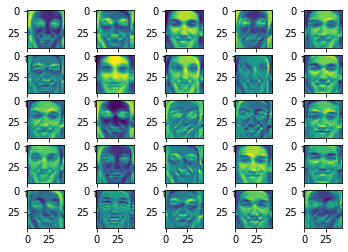

In [ ]:
# from https://towardsdatascience.com/convolutional-neural-networks-from-the-ground-up-c67bb41454e1
def convolution(image, filt, bias, s=1):
    '''
    Confolves `filt` over `image` using stride `s`
    '''
    (n_f, n_c_f, f, _) = filt.shape # filter dimensions
    n_c, in_dim, _ = image.shape # image dimensions
    
    out_dim = int((in_dim - f)/s)+1 # calculate output dimensions
    
    # ensure that the filter dimensions match the dimensions of the input image
    assert n_c == n_c_f, "Dimensions of filter must match dimensions of input image"
    
    out = np.zeros((n_f,out_dim,out_dim)) # create the matrix to hold the values of the convolution operation
    
    # convolve each filter over the image
    for curr_f in range(n_f):
        curr_y = out_y = 0
        # move filter vertically across the image
        while curr_y + f <= in_dim:
            curr_x = out_x = 0
            # move filter horizontally across the image 
            while curr_x + f <= in_dim:
                # perform the convolution operation and add the bias
                out[curr_f, out_y, out_x] = np.sum(filt[curr_f] * image[:,curr_y:curr_y+f, curr_x:curr_x+f]) + bias[curr_f]
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
        
    return out

# ###################################################
input_image = []
for i in range(0, 1):
  input_image.append(training_img[319])
input_image = np.array(input_image)

num_filters = 25

# randomly inilialized filters
filters = np.random.normal(size=(num_filters,1,5,5))
bias = np.zeros(num_filters)


output = convolution(input_image, filters, bias)
print(np.shape(output))

for i in range(0, 25):
    ax=plt.subplot(5,5,i+1)
    plt.imshow(output[i])


(25, 22, 22)


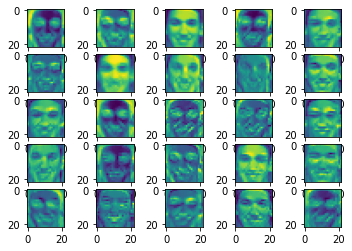

In [ ]:
def maxpool(image, f=2, s=2):
    
    #Downsample input `image` using a kernel size of `f` and a stride of `s`
    
    n_c, h_prev, w_prev = image.shape
    
    # calculate output dimensions after the maxpooling operation.
    h = int((h_prev - f)/s)+1 
    w = int((w_prev - f)/s)+1
    
    # create a matrix to hold the values of the maxpooling operation.
    downsampled = np.zeros((n_c, h, w)) 
    
    # slide the window over every part of the image using stride s. Take the maximum value at each step.
    for i in range(n_c):
        curr_y = out_y = 0
        # slide the max pooling window vertically across the image
        while curr_y + f <= h_prev:
            curr_x = out_x = 0
            # slide the max pooling window horizontally across the image
            while curr_x + f <= w_prev:
                # choose the maximum value within the window at each step and store it to the output matrix
                downsampled[i, out_y, out_x] = np.max(image[i, curr_y:curr_y+f, curr_x:curr_x+f])
                curr_x += s
                out_x += 1
            curr_y += s
            out_y += 1
    return downsampled


image_after_maxpool = maxpool(output)
print(np.shape(image_after_maxpool))
for i in range(0, 25):
  ax=plt.subplot(5,5,i+1)
  plt.imshow(image_after_maxpool[i])



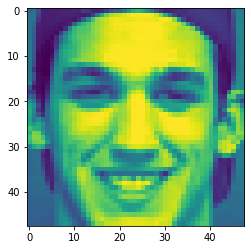

In [ ]:
plt.imshow(training_img[319])

# Convolutional Neural Network (Model building)

useful reference 

How to build model in Keras https://victorzhou.com/blog/keras-cnn-tutorial/

Understanding how convolutional works https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1

Quick guide for understanding convolutional kernel https://towardsdatascience.com/types-of-convolution-kernels-simplified-f040cb307c37



In [ ]:
# constucting the convelutional layer
def construct_empty_cnn():

  # tuning variables
  num_filters_l1 = 32
  num_filters_l2 = 64
  filter_size_l1 = 3
  filter_size_l2 = 3
  strides_l1 = (1,1)
  strides_l2 = (1,1)
  padding_l1 = "valid"
  padding_l2 = "valid"
  pool_size = (2,2)


  input_shape = (48,48,1)
  input_shape_12 = (46,46,32)
  input_shape_21 = (22,22,32)
  input_shape_22 = (20,20,64)


  # ------------------- sequential 
  cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(num_filters_l1, filter_size_l1, strides=strides_l1, 
                        padding=padding_l1, 
                        input_shape=input_shape,
                        activation="relu"),
    keras.layers.Conv2D(num_filters_l1, filter_size_l1, strides=strides_l1,
                        padding=padding_l1, 
                        input_shape=input_shape_12,
                        activation="relu"),
    keras.layers.MaxPooling2D(pool_size=pool_size),
    keras.layers.Conv2D(num_filters_l2, filter_size_l2, strides=strides_l2, 
                        padding=padding_l2, 
                        input_shape=input_shape_21,
                        activation="relu"),
    keras.layers.Conv2D(num_filters_l2, filter_size_l2, strides=strides_l2,
                        padding=padding_l2, 
                        input_shape=input_shape_22,
                        activation="relu"),
    keras.layers.MaxPooling2D(pool_size=pool_size),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(7, activation="softmax") 
  ])


  return cnn_model

# construct the model.
cnn_model = construct_empty_cnn()
cnn_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 20, 20, 64)        18496     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 18, 18, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 5184)            

In [ ]:
# set up training labels to a correct format
training_labels = np.argmax(pd.get_dummies(training_class).to_numpy(), axis=1)
validation_labels = np.argmax(pd.get_dummies(validation_class).to_numpy(), axis=1)
testing_labels = np.argmax(pd.get_dummies(testing_class).to_numpy(), axis=1)

#file_dir = '/content/drive/My Drive/CS486 Project/code/trained_cnn_network.h5'
#history_dir = '/content/drive/My Drive/CS486 Project/code/trained_history.csv'
file_dir = '/content/drive/My Drive/code/trained_cnn_network.h5'
history_dir = '/content/drive/My Drive/code/trained_history'


# if False, load trained model from drive
# if True, train a new model
retrain = True

# if trained already, load the trained model to save time
if os.path.exists(file_dir) and os.path.exists(history_dir) and not retrain:
    cnn_model = tf.keras.models.load_model(file_dir)
    training_history = pd.read_csv(history_dir)

    # if want to add more train epoch to exsiting model, uncomment below:
    #   this will result in overwritting training history to the new one.
    
    # cnn_model.fit(training_img.reshape(list(training_img.shape) + [1]), 
    #                         training_labels, 
    #                         epochs=10,
    #                         validation_data=(validation_img.reshape(list(validation_img.shape) + [1]), 
    #                                           validation_labels))
    # training_history = pd.DataFrame(history.history)
    # training_history.to_csv(history_dir, index = False)
else:
    cnn_model = construct_empty_cnn()
    cnn_model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    history = cnn_model.fit(training_img.reshape(list(training_img.shape) + [1]), 
                            training_labels, 
                            epochs=10,
                            validation_data=(validation_img.reshape(list(validation_img.shape) + [1]), 
                                              validation_labels))
    cnn_model.save(file_dir)
    training_history = pd.DataFrame(history.history)
    training_history.to_csv(history_dir, index = False)

Epoch 1/10
19/19 [==============================] - 5s 276ms/step - loss: 5.5087 - accuracy: 0.3622 - val_loss: 1.5734 - val_accuracy: 0.4728
Epoch 2/10
19/19 [==============================] - 5s 270ms/step - loss: 1.0449 - accuracy: 0.6565 - val_loss: 0.9705 - val_accuracy: 0.6259
Epoch 3/10
19/19 [==============================] - 5s 268ms/step - loss: 0.5638 - accuracy: 0.8146 - val_loss: 0.5171 - val_accuracy: 0.8163
Epoch 4/10
19/19 [==============================] - 5s 268ms/step - loss: 0.2663 - accuracy: 0.9133 - val_loss: 0.2535 - val_accuracy: 0.9218
Epoch 5/10
19/19 [==============================] - 5s 268ms/step - loss: 0.1197 - accuracy: 0.9643 - val_loss: 0.3410 - val_accuracy: 0.9082
Epoch 6/10
19/19 [==============================] - 5s 269ms/step - loss: 0.1219 - accuracy: 0.9490 - val_loss: 0.3040 - val_accuracy: 0.9184
Epoch 7/10
19/19 [==============================] - 5s 276ms/step - loss: 0.1054 - accuracy: 0.9694 - val_loss: 0.1583 - val_accuracy: 0.9524
Epoch 

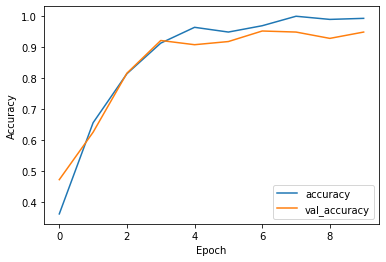

In [ ]:
# plot the data
# could choose loss, val_loss, accuracy, val_accuracy to drop
training_data = training_history.drop(["loss","val_loss"], axis=1)
for i in training_data.head():
    plt.plot(i, data = training_data)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# test the model on testing data

cnn_model.evaluate(testing_img.reshape(list(testing_img.shape) + [1]), testing_labels)

4/4 [==============================] - 0s 32ms/step - loss: 0.2512 - accuracy: 0.9694


[0.2512036859989166, 0.9693877696990967]

# Autoencoder

这个我觉得如果你是想对比的话这最好换个名字，我觉得Autoencoder 一般是指有encoder和decoder，把input 转换成一个 high dimensional representation 再转换回 input (estimation of input)的过程，我们这里应该用不到。 或者如果你是想显示decode出来的图的话那可以补一个decoder试一下。

In [ ]:
# compare model using same padding instead of valid padding ###################

def encoder(input_img):
    #encoder
    from keras.layers.normalization import BatchNormalization
    num_filters_l1 = 32
    num_filters_l2 = 64
    filter_size_l1 = 3
    filter_size_l2 = 3
    strides_l1 = (1,1)
    strides_l2 = (1,1)
    padding_l1 = "same" 
    padding_l2 = "same"
    pool_size = (2,2)


    conv1 = keras.layers.Conv2D(num_filters_l1, filter_size_l1, strides=strides_l1, 
                                padding=padding_l1, 
                                activation="relu")(input_img) #28 x 28 x 32
    #conv1 = BatchNormalization()(conv1)
    conv1 = keras.layers.Conv2D(num_filters_l1, filter_size_l1, strides=strides_l1,
                                padding=padding_l1, 
                                activation="relu")(conv1)
    #conv1 = BatchNormalization()(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32


    conv2 = keras.layers.Conv2D(num_filters_l2, filter_size_l2, strides=strides_l2, 
                                padding=padding_l2,
                                activation="relu")(pool1) #14 x 14 x 64
    #conv2 = BatchNormalization()(conv2)
    conv2 = keras.layers.Conv2D(num_filters_l2, filter_size_l2, strides=strides_l2,
                                padding=padding_l2, 
                                activation="relu")(conv2)
    #conv2 = BatchNormalization()(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64


    flat = keras.layers.Flatten()(pool2)
    den = keras.layers.Dense(128, activation='relu')(flat)
    den = keras.layers.Dense(7, activation='softmax')(den)
    # the code you have previously dnw. I change the above activation from relu to softmax ---Jason

    return den


In [ ]:

inp = keras.layers.Input((48,48,1))
code = encoder(inp)

autoencoder = keras.models.Model(inp,code)
autoencoder.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)       

In [ ]:
history = autoencoder.fit(training_img.reshape(list(training_img.shape) + [1]),
                          training_labels, 
                          epochs=10,
                          validation_data=(validation_img.reshape(list(validation_img.shape) + [1]),validation_labels))
training_history = pd.DataFrame(history.history)

Epoch 1/10
19/19 [==============================] - 7s 371ms/step - loss: 11.2563 - accuracy: 0.2602 - val_loss: 1.5459 - val_accuracy: 0.5272
Epoch 2/10
19/19 [==============================] - 7s 364ms/step - loss: 1.1114 - accuracy: 0.6548 - val_loss: 0.7139 - val_accuracy: 0.8061
Epoch 3/10
19/19 [==============================] - 7s 364ms/step - loss: 0.5736 - accuracy: 0.7959 - val_loss: 0.8153 - val_accuracy: 0.7041
Epoch 4/10
19/19 [==============================] - 7s 363ms/step - loss: 0.3479 - accuracy: 0.8776 - val_loss: 0.6557 - val_accuracy: 0.7891
Epoch 5/10
19/19 [==============================] - 7s 364ms/step - loss: 0.3539 - accuracy: 0.8707 - val_loss: 0.3620 - val_accuracy: 0.8741
Epoch 6/10
19/19 [==============================] - 7s 365ms/step - loss: 0.1407 - accuracy: 0.9643 - val_loss: 0.2126 - val_accuracy: 0.9252
Epoch 7/10
19/19 [==============================] - 7s 366ms/step - loss: 0.0593 - accuracy: 0.9864 - val_loss: 0.2025 - val_accuracy: 0.9286
Epoch

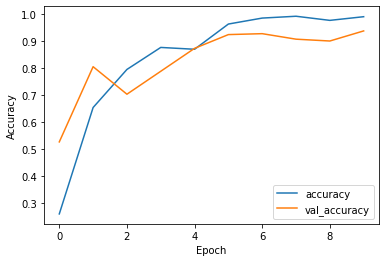

In [ ]:
training_data = training_history.drop(["loss","val_loss"], axis=1)
for i in training_data.head():
    plt.plot(i, data = training_data)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Define function for training and plotting results

In [ ]:
training_img = training_img.reshape(list(training_img.shape) + [1])
validation_img = validation_img.reshape(list(validation_img.shape) + [1])

def entire_training(model, train_inputs, train_labels, n_epochs, val_inputs, val_labels):
  model.compile(optimizer='adam',
                  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
  history = model.fit(train_inputs,
                      train_labels, 
                      epochs=n_epochs,
                      validation_data=(val_inputs,val_labels))
  training_history = pd.DataFrame(history.history)

  # plotting the graph
  training_results = training_history.drop(["loss","val_loss"], axis=1)
  for i in training_results.head():
      plt.plot(i, data = training_results)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.show()
  model.evaluate(testing_img.reshape(list(testing_img.shape) + [1]), testing_labels)
  return training_history


# Define models for comparison

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 18, 18, 64)        51264     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 9, 9, 64)          0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 5184)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               663680    
_________________________________________________________________
dense_36 (Dense)             (None, 7)               

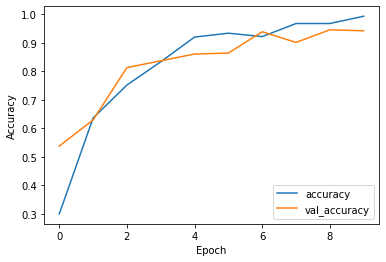

4/4 [==============================] - 0s 19ms/step - loss: 0.2699 - accuracy: 0.9388


In [ ]:
# -----------------------------------------------------------------------------
# constucting the convelutional layer 
# model with 2 Convolutional Layer with 5x5 kernel
def construct_cnn_2_5x5():

  # tuning variables
  num_filters_l1 = 32
  num_filters_l2 = 64
  filter_size_l1 = 5
  filter_size_l2 = 5
  strides_l1 = (1,1)
  strides_l2 = (1,1)
  padding_l1 = "valid"
  padding_l2 = "valid"
  pool_size = (2,2)


  input_shape = (48,48,1) # CNN: (input_size - kernel_size + 2*padding)/stride + 1  
  input_shape_21 = (22,22,32) # Maxpooling size/2


  cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(num_filters_l1, filter_size_l1, strides=strides_l1, 
                        padding=padding_l1, 
                        input_shape=input_shape,
                        activation="relu"),
    keras.layers.MaxPooling2D(pool_size=pool_size),
    keras.layers.Conv2D(num_filters_l2, filter_size_l2, strides=strides_l2, 
                        padding=padding_l2, 
                        input_shape=input_shape_21,
                        activation="relu"),
    keras.layers.MaxPooling2D(pool_size=pool_size),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(7, activation="softmax") 
  ])

  return cnn_model

# construct the model.
cnn_model_2_5x5 = construct_cnn_2_5x5()
cnn_model_2_5x5.summary()

# train the model
training_history_2_5x5 = entire_training(cnn_model_2_5x5, training_img, training_labels, 10, validation_img, validation_labels)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 44, 44, 32)        832       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 15488)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               1982592   
_________________________________________________________________
dense_38 (Dense)             (None, 7)                 903       
Total params: 1,984,327
Trainable params: 1,984,327
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
19/19 [==============================] - 1s 69ms/step - loss: 128.7724 - accuracy: 0.3282 - val_lo

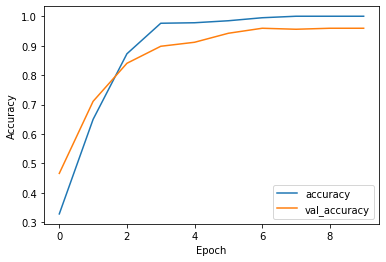

4/4 [==============================] - 0s 9ms/step - loss: 0.1251 - accuracy: 0.9694


In [ ]:
# -----------------------------------------------------------------------------
# constucting the convelutional layer 
# model with 1 Convolutional Layer with 5x5 kernel
def construct_cnn_1_5x5():

  # tuning variables
  num_filters_l1 = 32
  num_filters_l2 = 64
  filter_size_l1 = 5
  filter_size_l2 = 5
  strides_l1 = (1,1)
  strides_l2 = (1,1)
  padding_l1 = "valid"
  padding_l2 = "valid"
  pool_size = (2,2)


  input_shape = (48,48,1) # CNN: (input_size - kernel_size + 2*padding)/stride + 1  
  input_shape_21 = (22,22,32) # Maxpooling size/2


  cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(num_filters_l1, filter_size_l1, strides=strides_l1, 
                        padding=padding_l1, 
                        input_shape=input_shape,
                        activation="relu"),
    keras.layers.MaxPooling2D(pool_size=pool_size),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(7, activation="softmax") 
  ])

  return cnn_model

# construct the model.
cnn_model_1_5x5 = construct_cnn_1_5x5()
cnn_model_1_5x5.summary()

# train the model
training_history_1_5x5 = entire_training(cnn_model_1_5x5, training_img, training_labels, 10, validation_img, validation_labels)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 44, 44, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 22, 22, 32)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 15488)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 128)               1982592   
_________________________________________________________________
dense_40 (Dense)             (None, 7)                 903       
Total params: 1,993,063
Trainable params: 1,993,063
Non-trainable params: 0
___________________________________________

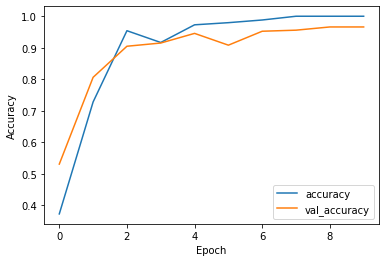

4/4 [==============================] - 0s 25ms/step - loss: 0.1557 - accuracy: 0.9796


In [ ]:
# -----------------------------------------------------------------------------
# constucting the convelutional layer 
# model with 2 Convolutional Layer with 3x3 kernel
def construct_cnn_1_2x3x3():

  # tuning variables
  num_filters_l1 = 32
  num_filters_l2 = 64
  filter_size_l1 = 3
  filter_size_l2 = 3
  strides_l1 = (1,1)
  strides_l2 = (1,1)
  padding_l1 = "valid"
  padding_l2 = "valid"
  pool_size = (2,2)


  input_shape = (48,48,1)
  input_shape_12 = (46,46,32)


  # ------------------- sequential 
  cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(num_filters_l1, filter_size_l1, strides=strides_l1, 
                        padding=padding_l1, 
                        input_shape=input_shape,
                        activation="relu"),
    keras.layers.Conv2D(num_filters_l1, filter_size_l1, strides=strides_l1,
                        padding=padding_l1, 
                        input_shape=input_shape_12,
                        activation="relu"),
    keras.layers.MaxPooling2D(pool_size=pool_size),

    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(7, activation="softmax") 
  ])

  return cnn_model

# construct the model.
cnn_model_1_2x3x3 = construct_cnn_1_2x3x3()
cnn_model_1_2x3x3.summary()

# train the model
training_history_1_2x3x3 = entire_training(cnn_model_1_2x3x3, training_img, training_labels, 10, validation_img, validation_labels)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_21 (Flatten)         (None, 2304)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 128)               295040    
_________________________________________________________________
dense_49 (Dense)             (None, 7)                 903       
Total params: 295,943
Trainable params: 295,943
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
19/19 [==============================] - 3s 183ms/step - loss: 0.0776 - accuracy: 0.9813 - val_loss: 0.6801 - val_accuracy: 0.9184
Epoch 2/10
19/19 [==============================] - 3s 177ms/step - loss: 0.0192 - accuracy: 0.9966 - val_loss: 0.6271 - val_accuracy: 0.9320
Epoch 3/10
19/19 [==============================] - 3s 178ms/step - loss: 0.0831 - accuracy: 

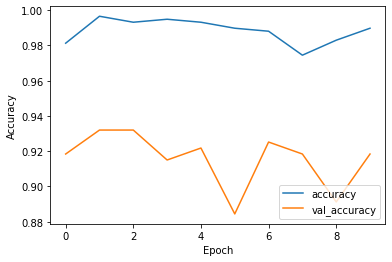

4/4 [==============================] - 0s 22ms/step - loss: 0.7749 - accuracy: 0.9286


In [ ]:
# Simple three level linear model
def construct_simple_deepNN():
  input_shape = (48,48,1)


  # ------------------- sequential 
  model = keras.models.Sequential([
                                       
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(7, activation="softmax") 
  ])

  return model

# construct the model.
simple_deepNN = construct_simple_deepNN()
simple_deepNN.summary()

# train the model
training_history_1_2x3x3 = entire_training(cnn_model_1_2x3x3, training_img, training_labels, 10, validation_img, validation_labels)


# Note I have updated the file and constructed the 3 model for comparison --- Jason